# Feature Extraction in Image Processing
Ćwiczenia wykorzystują bibliotekę OpenCV: `cv2` oraz `scikit-image`.



In [16]:
# Import potrzebnych bibliotek
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray

---
## 1. Analiza tekstury — Local Binary Pattern (LBP)

**Local Binary Pattern (LBP)** to prosty i skuteczny algorytm do ekstrakcji cech tekstury z obrazów. Opiera się na lokalnym porównaniu pikseli w sąsiedztwie każdego punktu obrazu.

### Jak działa LBP:
Dla każdego piksela (z wyłączeniem krawędzi):

1. Wybierz piksel centralny i jego 8 sąsiadów (macierz 3×3).
2. Porównaj każdego sąsiada z pikselem centralnym:
   - jeśli `sąsiad >= centrum`, zapisz `1`, w przeciwnym razie `0`.
3. Otrzymujesz 8-bitowy ciąg binarny → przekształć go na wartość dziesiętną.
4. Tę wartość przypisz do piksela w nowym obrazie LBP.

![Wizualizacja](threshold1.jpg)

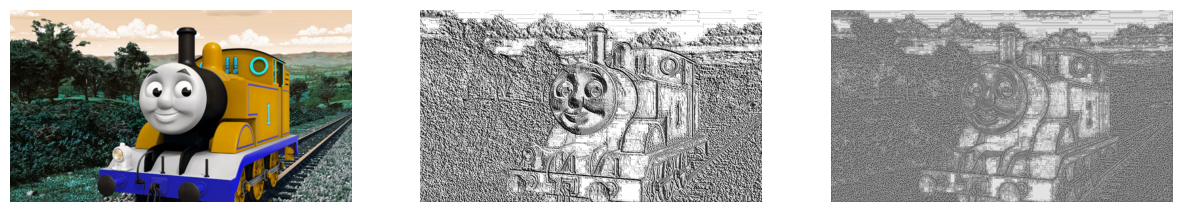

In [20]:
def get_pixel(img, center, x, y):
    
    new_value = 0
    
    try:
        #jesli sąsiadujacy piksel jest wiekszy lub rowny wartosci srodka to przypisz 1
        # jesli jest mniejszy to przypisz 0
        if img[x][y] >= center:
            new_value = 1
        else:
            new_value = 0

    except:
        # jesli nie ma takiego piksela to nic nie rob
        pass
    
    return new_value
 
#obliczanie LBP dla piksela
def lbp_calculated_pixel(img, x, y):
 
    center = img[x][y]
 
    val_ar = []
    
    # top_left
    val_ar.append(get_pixel(img, center, x-1, y-1))
    
    # top
    val_ar.append(get_pixel(img, center, x-1, y))
    
    # top_right
    val_ar.append(get_pixel(img, center, x-1, y + 1))
    
    # right
    val_ar.append(get_pixel(img, center, x, y + 1))
    
    # bottom_right
    val_ar.append(get_pixel(img, center, x + 1, y + 1))
    
    # bottom
    val_ar.append(get_pixel(img, center, x + 1, y))
    
    # bottom_left
    val_ar.append(get_pixel(img, center, x + 1, y-1))
    
    # left
    val_ar.append(get_pixel(img, center, x, y-1))
     
    # wartości są mnożone przez odpowiednie potęgi 2
    # i sumowane, aby uzyskać wartość LBP
    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val
 
img_bgr = cv2.imread('tomek.jpg')
 
height, width, _ = img_bgr.shape
 
# Konwersja obrazu do skali szarości
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# tworzenie pustej macierzy dla LBP o wymiarach obrazu
img_lbp = np.zeros((height, width),
                   np.uint8)
 
for i in range(0, height):
    for j in range(0, width):
        img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(img_bgr)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_lbp, cmap ="gray")
plt.axis('off')

wbudowana = local_binary_pattern(img_gray, P=8, R=1, method='uniform')
plt.subplot(1, 3, 3)
plt.imshow(wbudowana, cmap ="gray")
plt.axis('off')

plt.show()

---
## 2. Detekcja narożników
### Algorytm Harris
Wykrywa narożniki jako obszary o silnej zmianie intensywności w obu kierunkach. Oto jak działa:



#### 1. Gradienty obrazu:

$$
I_x = \frac{\partial I}{\partial x}, \quad I_y = \frac{\partial I}{\partial y}
$$


#### 2. Macierz struktury M:

$$
M = \begin{bmatrix}
\sum I_x^2 & \sum I_x I_y \\
\sum I_x I_y & \sum I_y^2
\end{bmatrix}
$$


#### 3. Funkcja odpowiedzi narożnika (R):

$$
R = \det(M) - k \cdot (\text{trace}(M))^2
$$

gdzie:
- $det(M)$ =  wyznacznik macierzy
- ${trace}(M)$ = suma przekątnej
- $k$ – współczynnik czułości (typowo 0.04–0.06)


#### 4. Interpretacja:

- $R \ll 0$ – krawędź
- $R \approx 0$ – obszar jednorodny
- $R >$ próg – narożnik ok


#### 5. Non-maximum suppression:

Na koniec zostają tylko lokalne maksima \(R\) przekraczające próg – to są narożniki.

#### 6. Intuicja:
-det(M) mierzy "siłę sygnału" w dwóch kierunkach — duża wartość sugeruje, że piksel różni się od otoczenia w obu osiach (czyli może to być narożnik).

-trace(M)^2 to suma wariancji — wysoka nawet dla samych krawędzi.

-Odejmując k · trace^2, eliminujemy silne odpowiedzi pochodzące tylko z krawędzi.


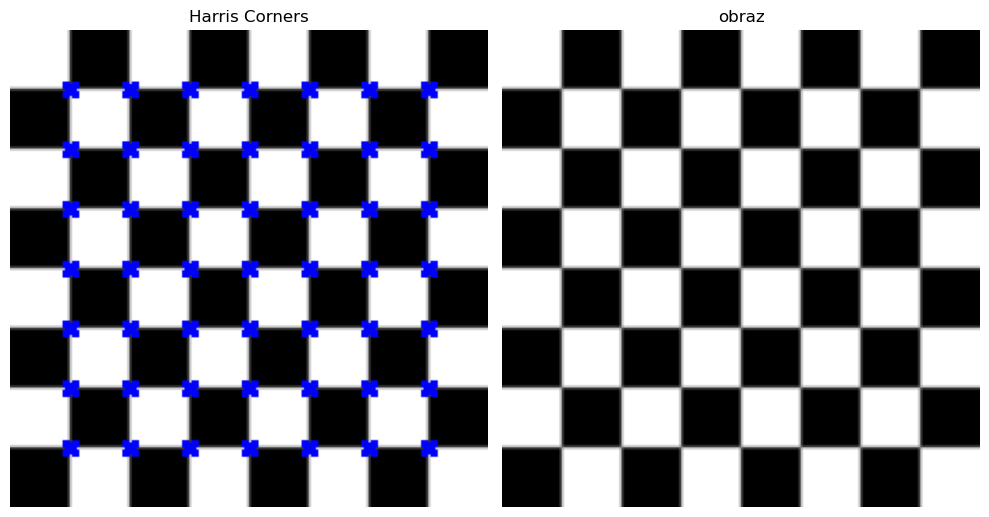

In [25]:
image = data.checkerboard()#jest juz szary
operatedImage = np.float32(image)

# stosuje alg Harris
dest = cv2.cornerHarris(operatedImage, 2, 5, 0.07)

# wyniki sa wzmocnione przez dilate
dest = cv2.dilate(dest, None)

# zmieniam szarosc na kolor
image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

#zaznaczam rogi
image_color[dest > 0.01 * dest.max()] = [0, 0, 255]

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.title("Harris Corners")
plt.imshow(image_color)
plt.axis('off')

plt.subplot(1, 2, 2)  
plt.title("obraz")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


---
## 3. Detekcja blobów — DoH (Determinant of Hessian)
Metoda DoH (Determinant of Hessian) wykrywa bloby – charakterystyczne skupiska pikseli – poprzez analizę drugich pochodnych obrazu.


#### Macierz Hessego:

$$
H = \begin{bmatrix}
I_{xx} & I_{xy} \\
I_{xy} & I_{yy}
\end{bmatrix}
$$

Gdzie:
- $ I_{xx}, I_{yy} $ – drugie pochodne w poziomie i pionie
- $ I_{xy} $ – pochodna mieszana


#### Wyznacznik macierzy Hessego:

$$
\text{det}(H) = I_{xx} \cdot I_{yy} - (I_{xy})^2
$$

- Gdy ${det}(H)$ ma dużą wartość → prawdopodobnie w tym miejscu znajduje się **blob**.


#### Algorytm:

1. Obliczenie pochodnych i det(H) dla każdej skali
2. Przeglądanie przestrzeni skala–pozycja
3. Wyszukiwanie lokalnych maksimów det(H)
4. Zwrócenie położenia i rozmiaru każdego blobu


#### Zalety:

- Czuła na małe i średnie bloby
- Skuteczna w obecności zakłóceń

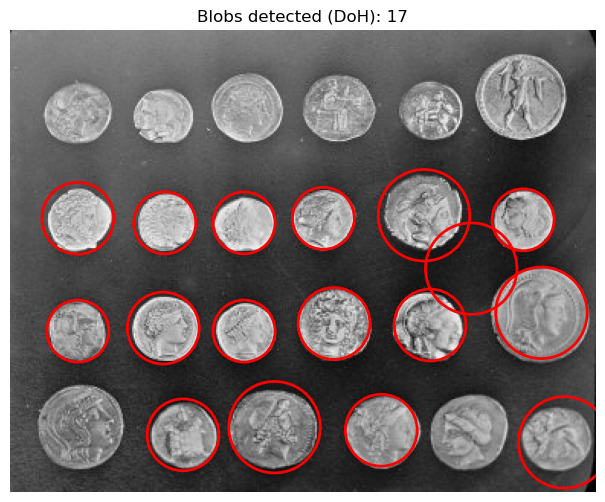

In [24]:
from skimage import data, feature, color
import matplotlib.pyplot as plt

# Wczytanie obrazu (np. monety)
image = data.coins()

# DoH blob detection
blobs_doh = feature.blob_doh(image, max_sigma=30, threshold=0.01)

# Wyświetlenie wyników
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image, cmap='gray')
for blob in blobs_doh:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)

ax.set_title(f"Blobs detected (DoH): {len(blobs_doh)}")
ax.axis('off')
plt.show()


---
## 4. Detekcja krawędzi - Algorytm Sobela
### Intuicja algorytmu Sobela

Sobel to filtr krawędziowy, który wykrywa miejsca nagłej zmiany jasności – czyli **krawędzie**.

#### Obliczanie gradientu:

- Wykorzystuje dwa filtry:
  -$ G_x $ – pionowe krawędzie
  -$ G_y $ – poziome krawędzie

$$
G_x =
\begin{bmatrix}
-1 & 0 & +1 \\
-2 & 0 & +2 \\
-1 & 0 & +1
\end{bmatrix}
\quad
G_y =
\begin{bmatrix}
+1 & +2 & +1 \\
0  & 0  & 0 \\
-1 & -2 & -1
\end{bmatrix}
$$

#### Obliczenia:

- Gradient poziomy: $$ S_x = I * G_x $$
- Gradient pionowy: $$ S_y = I * G_y $$
- Wielkość gradientu: $$ G = \sqrt{S_x^2 + S_y^2} $$


#### Zastosowanie:

- Wykrywanie konturów
- Wstępny krok w bardziej złożonych algorytmach (np. Canny)
- Łagodna reakcja na szum dzięki wygładzaniu





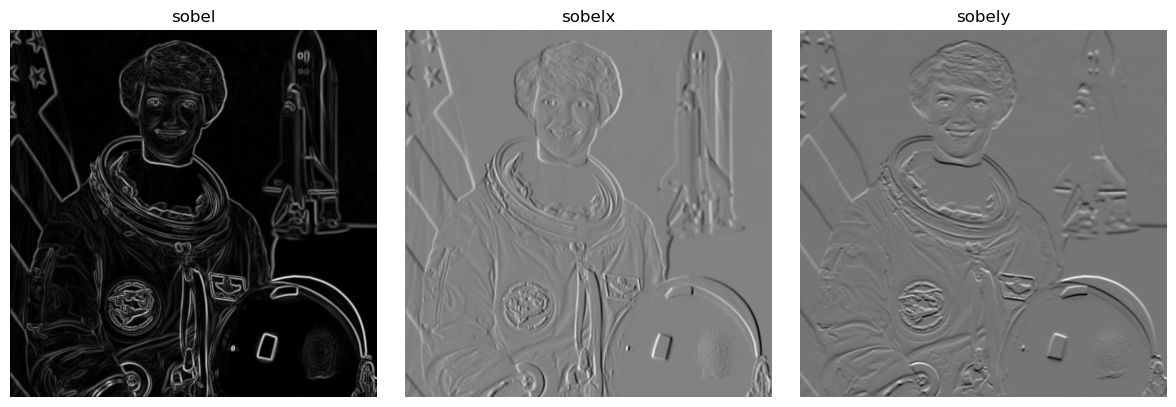

In [22]:
img = data.astronaut()
# Konwersja obrazu do skali szarości
img = rgb2gray(img)

# Sobel
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
sobel = np.sqrt(sobelx**2 + sobely**2)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("sobel")
plt.imshow(sobel, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("sobelx")
plt.imshow(sobelx, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("sobely")
plt.imshow(sobely, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

---
## Zadania

**Zadanie 1:** Załaduj obraz z skimage.data.camera() i zastosuj 2 różne detektory krawędzi:

-Sobel(powyżej)

-Canny- funkcja z OpenCV: cv2.Canny(gray, threshold1=100, threshold2=200)

Następnie porównaj rezultaty:

-Który z algorytmów daje najostrzejsze kontury?

-Gdzie występują szumy?

-Jak zmiana progów w Canny wpływa na wynik?

**Zadanie 2:** Wykorzystaj `skimage.feature.local_binary_pattern` do obliczenia LBP z `method='uniform'`. Następnie porównaj histogramy standardowego i ujednoliconego LBP.

**Zadanie 3:** Wczytaj obraz skimage.data.camera() i wykonaj detekcję blobów za pomocą metody DoH oraz poprzez cv2.SimpleBlobDetector z OpenCV

-Ile blobów wykryto w każdej z metod?

-Jakie są różnice w dokładności położenia i rozmiaru?

-Czy algorytmy wykrywają obiekty o różnych rozmiarach?